# `JobTopGun - Job Title Classification`: Kaggle Competition

This notebook outlines the process followed to participate in the [JobTopGun - job title classification](https://www.kaggle.com/competitions/jobtopgun-job-title-classification/submissions). Our task is to classify the job titles into 597 occupation classes and submit them for evaluation. Competition metric is [Macro F1-score](https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f), which treat
every class equally regardless of the number of their supports.

Summary Report [here](https://docs.google.com/document/d/1XjDd0R8NmnWSp4_U-8EaDRIAHS3f-MD3OmTIUYJivzw/edit?usp=sharing) 

What I have tried but not in this notebook
- TF-IDF + Logistic Regression
- Hierarchical classification (Classify top-level label first, then bottom level)
- Synonyms Augmentation

# Set up

In [ ]:
!pip install tensorflow-text
!pip install pythainlp
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install python-crfsuite

In [2]:
import nltk
nltk.download('omw-1.4') # For PythaiNLP's NER for Thai
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import regex
from pythainlp import word_tokenize
import joblib

In [4]:
import warnings
warnings.filterwarnings("ignore", category= UserWarning)

# Data Preprocessing

In [7]:
data_df = pd.read_csv('train.csv')
display(data_df.head())

,job_title,occupation_group,occupation,occupation_group_index,occupation_index
0,ผู้แทนฝ่ายบริหาร,Top Level Executive,Executive Manager,142,211
1,เภสัชกร สาขาแหลมฉบัง,Pharmacist,Pharmacist,107,413
2,ครูผู้สอนวิชาสุขศึกษา,Teacher,Health and Physical Education Teacher,140,276
3,ATC,Air Traffic Control,Air Traffic Control,7,23
4,Energy Monitoring Engineer,Engineering,Energy Engineer,50,195


In [8]:
# Remove duplicates
print(f"Before:\t{len(data_df)}")
data_df.drop_duplicates(inplace=True)
print(f"After:\t{len(data_df)}")

Before:	8000
After:	6538


# Text Preprocessing

In [9]:
def remove_html_tags(text):
  html_pattern = '<.*?>'
  return re.sub(html_pattern, '', text)

def remove_punc(text):
  punc_pattern = r"[()!/]"
  return re.sub(punc_pattern, " ", text)

def contains_only_punc_num(text):
  pattern = r"^(?:\p{P}|\d)+$"
  return bool(regex.match(pattern, text))

In [10]:
# Load stop words list
from pythainlp.corpus import thai_stopwords
from nltk.corpus import stopwords

loads = list(thai_stopwords()) + stopwords.words('english')
false_ls = ["it","d"]
stop_words = [word for word in loads if word not in false_ls]

In [11]:
def clean_tokens(tokens):
    filter_list = [ "required","urgent","urgenty","urgently","ด่วน",\
                    "position","positions","ตำแหน่ง","อัตรา","many",\
                    "จำนวน","full","time", "full-time", "fulltime","ประจำ",\
                    "part","time","part-time","parttime","สาขา","งาน",\
                    "รับสมัคร","job","code","id","k"]
    filter_list += stop_words
    res = []
    for token in tokens:
        if not ((token.lower() in filter_list) or (contains_only_punc_num(token))):
            res.append(token)
    return res

In [12]:
# NER for location words detection
from pythainlp.tag import NER
import spacy

eng_ner = spacy.load("en_core_web_sm")
thai_ner = NER("thainer")

Corpus: thainer
- Downloading: thainer 1.5


  0%|          | 0/1637304 [00:00<?, ?it/s]

In [13]:
# Remove Location words using Name-Entity Recognition(NER) Models
def rmv_loc_words(text, eng_ner, thai_ner):
  # For English
  eng_text = re.sub(r'[\u0E00-\u0E7F]+', '', text)
  doc = eng_ner(eng_text)
  for ent in doc.ents:
    if ent.label_ in ["GPE","LOC"]:
      if (ent.text).lower() not in ["visualizer","media","designers","freelance"]:
        
        text = text.replace(ent.text, '')

  # For Thai
  tags = thai_ner.tag(text, pos=False)
  locs = [tag[0] for tag in tags if "LOCATION" in tag[1] if tag[0]]
  if len(locs)==1:
    text = text.replace(locs[0], '')
  else:
    for loc in locs[1:]:
      text = text.replace(loc, '')
  return text

In [14]:
def process_text(text, eng_ner, thai_ner):
    # pre rules
    text = text.strip()
    text = re.sub(r'\u200b', '', text)
    text = remove_html_tags(text)
    text = remove_punc(text)
    text = rmv_loc_words(text, eng_ner, thai_ner)

    # tokenize
    tokens = [word.lower() for word in word_tokenize(text) if word and not re.search(pattern=r"\s+", string=word)]
    
    # post rules
    tokens = clean_tokens(tokens)
    
    # return ' '.join(tokens)
    return tokens

In [15]:
# Test cases

texts = ['"Medical Doctor (Wellness Centre) - Phuket, Thailand"', \
        "เจ้า​หน้าที่​บ​ริ​การ​ลูก​ค้า",\
        'QA Supervisor<br>(Job Code : QAC 0810031-2)',\
        "<font color=red><b>รับสมัครด่วนมาก!!!</font color></b> STB Installation Technician (ช่างเทคนิคติดตั้งเคเบิลทีวีระบบจานดาวเทียม)",\
        "ครูประจำชั้น",\
        "เภสัชกร (Full Time/ Part Time) หลายอัตรา ไม่ต้องขึ้นเวร (ศูนย์สุขภาพและศัลยกรรมความงามครบวงจรตรัยญา)",\
        '"ครูสอนเสริมทักษะ เด็กประถม,มัธยม(PartTime) สาขา สาทร,ประชาอุทิศ หรือ เพชรเกษม (หนองแขม)"',\
        ]
for text in texts:
  tokens = process_text(text, eng_ner, thai_ner)
  display(" ".join(tokens))

Corpus: pos_lst20_perceptron
- Downloading: pos_lst20_perceptron 0.2.4


  0%|          | 0/9512053 [00:00<?, ?it/s]

'medical doctor wellness centre'

'เจ้าหน้าที่ บริการ ลูกค้า'

'qa supervisor qac'

'stb installation technician ช่างเทคนิค ติดตั้ง เคเบิลทีวี ระบบ จานดาวเทียม'

'ครูประจำชั้น'

'เภสัชกร ไม่ต้อง เวร ศูนย์ สุขภาพ ศัลยกรรม ความงาม ครบวงจร ตรัย ญา'

'ครู สอน เสริม ทักษะ เด็กประถม มัธยม สาทร เพชรเกษม'

In [16]:
# Save preprocessed data
prep = []
for text in data_df.job_title:
    prep.append(" ".join(process_text(text, eng_ner, thai_ner)))
data_df["preprocessed"] = prep
data_df.preprocessed.to_csv("prep.csv", index=False)
data_df.to_csv("train_prep.csv", index=False)

# Train-validation Split

In [17]:
prep_df = pd.read_csv('train_prep.csv')
prep_df.dropna(inplace=True)
display(prep_df.head())

,job_title,occupation_group,occupation,occupation_group_index,occupation_index,preprocessed
0,ผู้แทนฝ่ายบริหาร,Top Level Executive,Executive Manager,142,211,ผู้แทน ฝ่ายบริหาร
1,เภสัชกร สาขาแหลมฉบัง,Pharmacist,Pharmacist,107,413,เภสัชกร แหลมฉบัง
2,ครูผู้สอนวิชาสุขศึกษา,Teacher,Health and Physical Education Teacher,140,276,ครูผู้สอน วิชา สุขศึกษา
3,ATC,Air Traffic Control,Air Traffic Control,7,23,atc
4,Energy Monitoring Engineer,Engineering,Energy Engineer,50,195,energy monitoring engineer


Sales                         192
Administrator                 103
Engineer                       62
Technician                     57
Quality Control                49
                             ... 
Lifeguard                       3
Personal Trainer                2
Executive                       2
Category Administrative         2
Deputy Permanent Secretary      2
Name: occupation, Length: 597, dtype: int64

Text(0.5, 1.0, 'Prevalence')

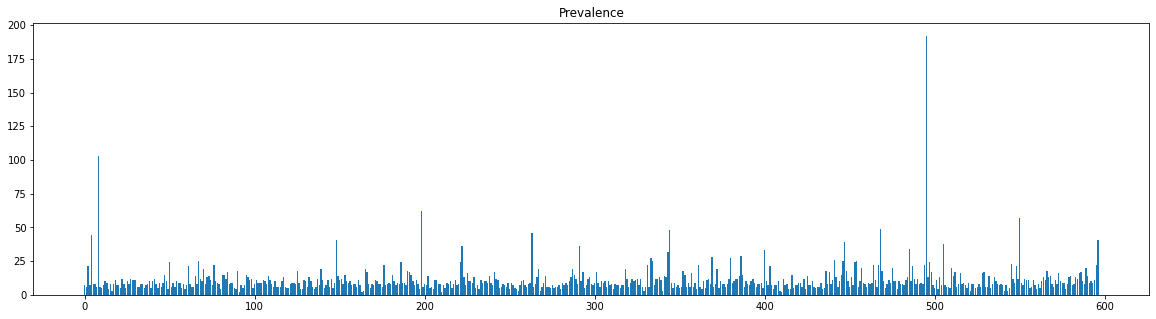

In [18]:
# Prevalence -> Class Imbalance detected
display(prep_df["occupation"].value_counts())
val_count = prep_df["occupation_index"].value_counts()

plt.figure(figsize=(20,5))
plt.bar(val_count.index, val_count.values)
plt.title("Prevalence")

In [19]:
from sklearn.model_selection import train_test_split

X_all = np.array(prep_df.preprocessed)
y_all = np.array(prep_df.occupation_index)

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, test_size=0.1, random_state = 99, stratify=y_all)
X_train.shape, X_valid.shape

((5877,), (654,))

In [20]:
# Save train set and validate set
data = pd.DataFrame({'texts': X_train, 'category': y_train})
data.to_csv("prep_train.csv", index=False)

data = pd.DataFrame({'texts': X_valid, 'category': y_valid})
data.to_csv("prep_valid.csv", index=False)

# Augmentation / Variation of train set

In [21]:
# Load train set
Xy_train = pd.read_csv('prep_train.csv')
X_train = Xy_train.texts
y_train = Xy_train.category

## Remove low frequency words
- pros: remove proper noun eg. locations, organizations, ...
- cons: also remove word that contains sentiment

In [24]:
# Get tokens frequency
vocab = []
for text in X_train:
    vocab += word_tokenize(text)
tokens, counts = np.unique(vocab, return_counts=True)
df = pd.DataFrame({'words': tokens, 'counts': counts}).sort_values("counts", ascending=False)
df.to_csv("tokens_counts.csv", index=False)

In [25]:
min_fq = 2

tokens_counts_df = pd.read_csv("tokens_counts.csv")
token_count = tokens_counts_df.set_index('words').to_dict('dict')['counts']

rlf_X_train = []
for text in X_train:
    tokens = [word for word in word_tokenize(text) if word and not re.search(pattern=r"\s+", string=word)]
    res = []
    for token in tokens:
        if token_count[token]>=min_fq:
            res.append(token)
    if res == []:
        res = tokens
    rlf_X_train.append(" ".join(res))

In [26]:
# Save alternate train set
data = pd.DataFrame({'texts': rlf_X_train, 'category': y_train})
data.to_csv("prep_train_rlf.csv", index=False)

## Add Occupation Mapper Class name

In [22]:
# Add Occupation Mapper Class name to the data
occ_df = pd.read_csv('occupation_mapper.csv').iloc[:-1,:]
occ_title = []
for text in occ_df.occupation:
  occ_title.append(" ".join(process_text(text, eng_ner, thai_ner)))
aug_X_train = pd.concat([X_train, pd.Series(occ_title)], axis=0)
aug_y_train = pd.concat([y_train, occ_df.occupation_index], axis=0)

In [23]:
# Save alternate train set
data = pd.DataFrame({'texts': aug_X_train, 'category': aug_y_train})
data.to_csv("prep_train_Oc.csv", index=False)

# Models

In [27]:
# Evaluation Report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate(y, y_pred):
  accuracy = accuracy_score(y, y_pred)
  precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred, average="macro")

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-score:", f1_score)
  return f1_score

In [30]:
# Load train set and validate set 

# Xy_train = pd.read_csv('prep_train.csv')
Xy_train = pd.read_csv('prep_train_Oc.csv')
# Xy_train = pd.read_csv('prep_train_rlf.csv')
# Xy_train = pd.read_csv('prep_train_rlfOc.csv')
Xy_train.dropna(inplace=True)
Xy_valid = pd.read_csv('prep_valid.csv')
Xy_valid.dropna(inplace=True)

X_train = Xy_train.texts
y_train = Xy_train.category
X_valid = Xy_valid.texts
y_valid = Xy_valid.category

## Text Encoder

### Universal Sentence Encoder (USE)

In [31]:
# Load USE model that support both Thai and English
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
from tensorflow_text import SentencepieceTokenizer

model_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
use_model = hub.load(model_url)

In [32]:
def batch_feed(texts, batch_size=64):
  """Feed the text as batches to avoid an OOM problem"""
  results = []
  for i in range(0, len(texts), batch_size):
    vectors = use_model(texts[i:i+batch_size])
    vectors = vectors.numpy() # Convert from tf.Tensor to numpy array
    results.append(vectors)
  results = np.concatenate(results, axis=0)
  return results

In [33]:
enc_X_train = batch_feed(X_train)
enc_X_valid = batch_feed(X_valid)

enc_X_train.shape, y_train.shape

((6473, 512), (6473,))

## Classifier

### Logistic Regression

In [34]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

train = "Oc"
for solver in ['lbfgs']:
  for c in [4,6,8]:
    print(solver, c)
    model = LogisticRegression(C=c, solver=solver, class_weight="balanced")

    # Train the model
    model.fit(enc_X_train, y_train)

    # Evaluate
    display(model.score(enc_X_train, y_train))
    y_pred = model.predict(enc_X_valid)
    evaluate(y_valid, y_pred)
    
    # Save the model
    joblib.dump(model, f'lgr_{train}_{solver[:4]}_c{c:03d}.joblib')
    print()

lbfgs 4


0.8016375714506411

Accuracy: 0.6131498470948012
Precision: 0.5530083857442348
Recall: 0.6223303541873552
F1-score: 0.563695717280623

lbfgs 6


0.8342345125907616

Accuracy: 0.6162079510703364
Precision: 0.5545540796963946
Recall: 0.6214188221978095
F1-score: 0.5640917026803305

lbfgs 8


0.8532365209331068

Accuracy: 0.6192660550458715
Precision: 0.5557063025694203
Recall: 0.6195317190314189
F1-score: 0.5649797815197055



### Support Vector Machine (SVM)

In [35]:
# SVC
from sklearn.svm import LinearSVC

train = "Oc"
for c in [2,3,4]:
    print(c)
    model = LinearSVC(C=c, dual=False, class_weight="balanced", random_state=99)

    # Train the model
    model.fit(enc_X_train, y_train)

    # Evaluate
    display(model.score(enc_X_train, y_train))
    y_pred = model.predict(enc_X_valid)
    evaluate(y_valid, y_pred)

    # Save the model
    joblib.dump(model, f'svc_{train}_c{c:02d}.joblib')
    print()

2


0.9100880580874401

Accuracy: 0.6146788990825688
Precision: 0.5522999369880277
Recall: 0.6204357775345737
F1-score: 0.5639830480834837

3


0.9239919666306194

Accuracy: 0.617737003058104
Precision: 0.5515873015873016
Recall: 0.6249089390142022
F1-score: 0.5651991849880048

4


0.9297080179205932

Accuracy: 0.6100917431192661
Precision: 0.5432698412698412
Recall: 0.6161203007518797
F1-score: 0.5575445084016513



### Deep Learning

In [39]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Hyperparams
num_labels = 597
num_epochs = 20
batch_size = 64
USE_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3", trainable=False)

# Create the model
model = Sequential()
model.add(Input(shape=[], dtype=tf.string))
model.add(USE_layer)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_labels, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=num_epochs, batch_size=batch_size)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 512)               85213184  
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 597)               306261    
                                                                 
Total params: 85,782,101
Trainable params: 568,917
Non-trainable params: 85,213,184
_________________________________________________________________
Epoch 1/20
102/102 [==============================] - 83s 609ms/step - loss: 6.0011 - accuracy: 0.0380 - val_loss: 5.2890 - val_accuracy: 0.0841
Epoch 2/20
102/102 [===

# Submission

In [36]:
# Pipeline
def pipeline(X, Encoder, Classifier):
  # Preprocess
  X_test = []
  for text in X:
      X_test.append(" ".join(process_text(text, eng_ner, thai_ner)))

  # Text Encoder
  enc_X_test = Encoder(X_test)

  # Classifier
  y_pred = model.predict(enc_X_test)

  return y_pred

In [36]:
# Load Model
model_name = 'lgr_Oc_lbfg_c008'
model = joblib.load(f'{model_name}.joblib')

# Prediction
test_df = pd.read_csv("test_for_submission.csv")
X_test = test_df.job_title
y_pred = pipeline(X=X_test, Encoder=batch_feed, Classifier=model)

In [37]:
# Save prediction in submission format
df = pd.Series(y_pred, name='Predicted')
df.index.name = 'Id'
df.to_csv(f"{model_name}_submission.csv")

---